In [1]:
import xgboost as xgb 
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_target = df['SUBCLASS']

data = df.drop(columns=['ID', 'SUBCLASS'])
df_test.drop(columns=['ID'], inplace=True)
data

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2,R895R,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6197,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6198,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,T181S,WT
6199,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [3]:
disease_list = df.SUBCLASS.unique()
disease_list

array(['KIPAN', 'SARC', 'SKCM', 'KIRC', 'GBMLGG', 'STES', 'BRCA', 'THCA',
       'LIHC', 'HNSC', 'PAAD', 'OV', 'PRAD', 'UCEC', 'LAML', 'COAD',
       'ACC', 'LGG', 'LUSC', 'LUAD', 'CESC', 'PCPG', 'THYM', 'BLCA',
       'TGCT', 'DLBC'], dtype=object)

1. 처음에는 각 질병(암)마다 WT이 아닌(유전체 암 발현된)개수 5개 이상인 유전체들을 1차로 수집하고,
2. 암별로 transaction의 개수와 발현된 유전체 개수의 불균형이 심하고, 암마다 유의미한 유전체의 개수가 천차만별이라,
각 암 별로 의미있는 유전체의 개수를 공동발현한 유전체들을 추출하기 위해 상관관계 상위 >0.5로 다시 뽑는다. 
3.이 유전체 SET을 기반으로 DataFrame을 새로 만들고, 각 질병별 선정된 유전체들 외의 유전체들 값들을 WT처럼 0으로 cleansing(noise 제거)처리하고,
4. XGBoost, RF, 등으로 학습 후 결과를 도출해본다.


In [4]:
from collections import defaultdict
import numpy as np
def get_gene_dictionary():
    main_genes = defaultdict()
    for d in disease_list:
        count_df = df[df.SUBCLASS==d].apply(lambda x : x!='WT').agg(sum)
        count_df = count_df[2:].reset_index(name='count')        
        gene_list = count_df[count_df['count']>5]['index'].values
        main_genes[d]= gene_list
    return main_genes
main_genes = get_gene_dictionary()

In [4]:
for k, v in main_genes.items():
    print(k, len(v))
    #extract_genes = extract_th(k)
    #print(len(extract_genes))

KIPAN 286
SARC 31
SKCM 2112
KIRC 68
GBMLGG 147
STES 2034
BRCA 691
THCA 4
LIHC 106
HNSC 334
PAAD 22
OV 47
PRAD 16
UCEC 2006
LAML 9
COAD 936
ACC 51
LGG 16
LUSC 587
LUAD 468
CESC 175
PCPG 3
THYM 1
BLCA 209
TGCT 14
DLBC 17


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
def drawing(dname):
    ccdf = df[df.SUBCLASS==dname].loc[:, main_genes.get(dname)]
    for c in ccdf.columns:
        ccdf[c] = ccdf[c].apply(lambda x : 0 if x =='WT' else len(str(x).split(' ')))
    sns.clustermap(ccdf.corr(), 
            annot = True,      # 실제 값 화면에 나타내기
            cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
            vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
            )   

In [9]:
dname='BRCA'
drawing(dname)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x15a21b880> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [10]:
drawing('SARC')


NameError: name 'total' is not defined

In [1]:
#drawing('SKCM')


In [ ]:
drawing('KIRC')


In [ ]:
drawing('GBMLGG')


In [ ]:
drawing('STES')


In [ ]:
drawing('THCA')

In [ ]:
drawing('LIHC')


In [ ]:
drawing('HNSC')


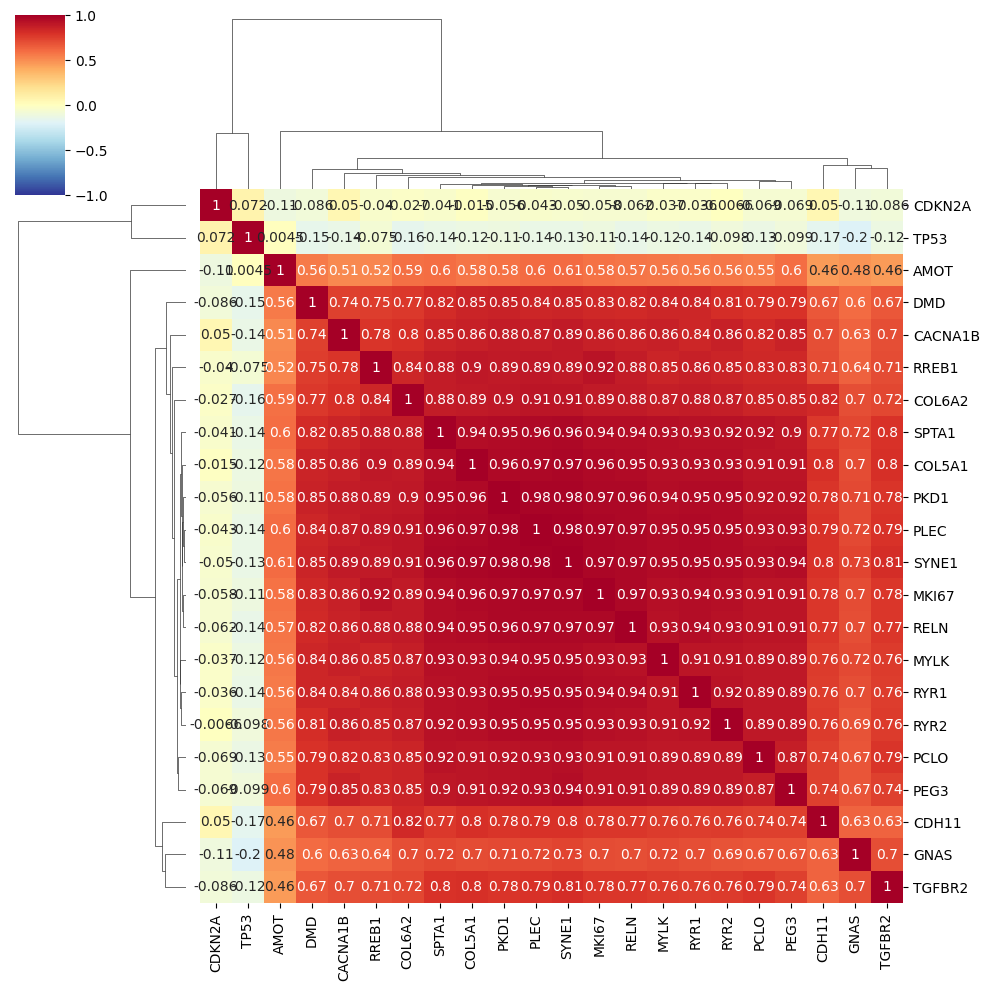

In [11]:
 
    
drawing('PAAD')


In [ ]:
drawing('OV')


In [ ]:
drawing('PRAD')


In [ ]:
drawing('UCEC')


In [ ]:
drawing('LAML')


In [ ]:
drawing('COAD')


In [ ]:
drawing('ACC')


In [ ]:
drawing('LGG')


In [ ]:
drawing('LUSC')


In [ ]:
drawing('LUAD')


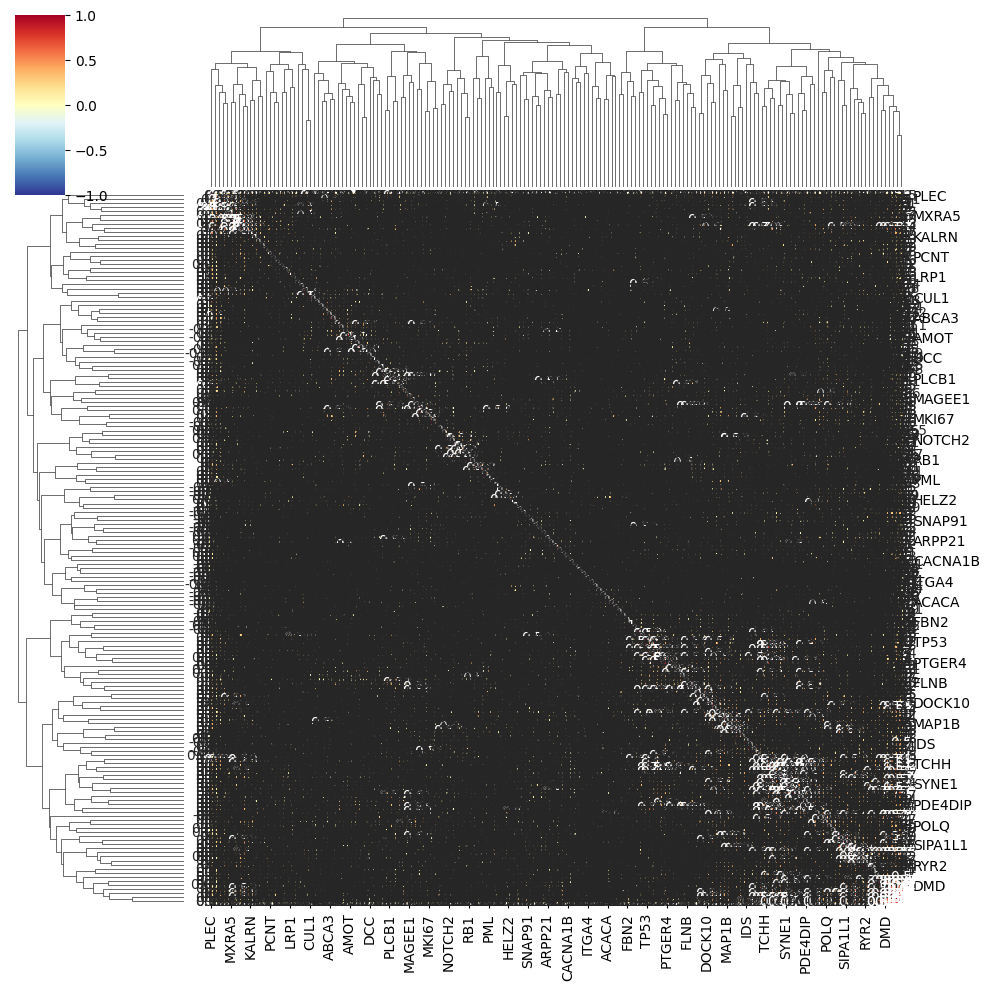

In [10]:
drawing('CESC')


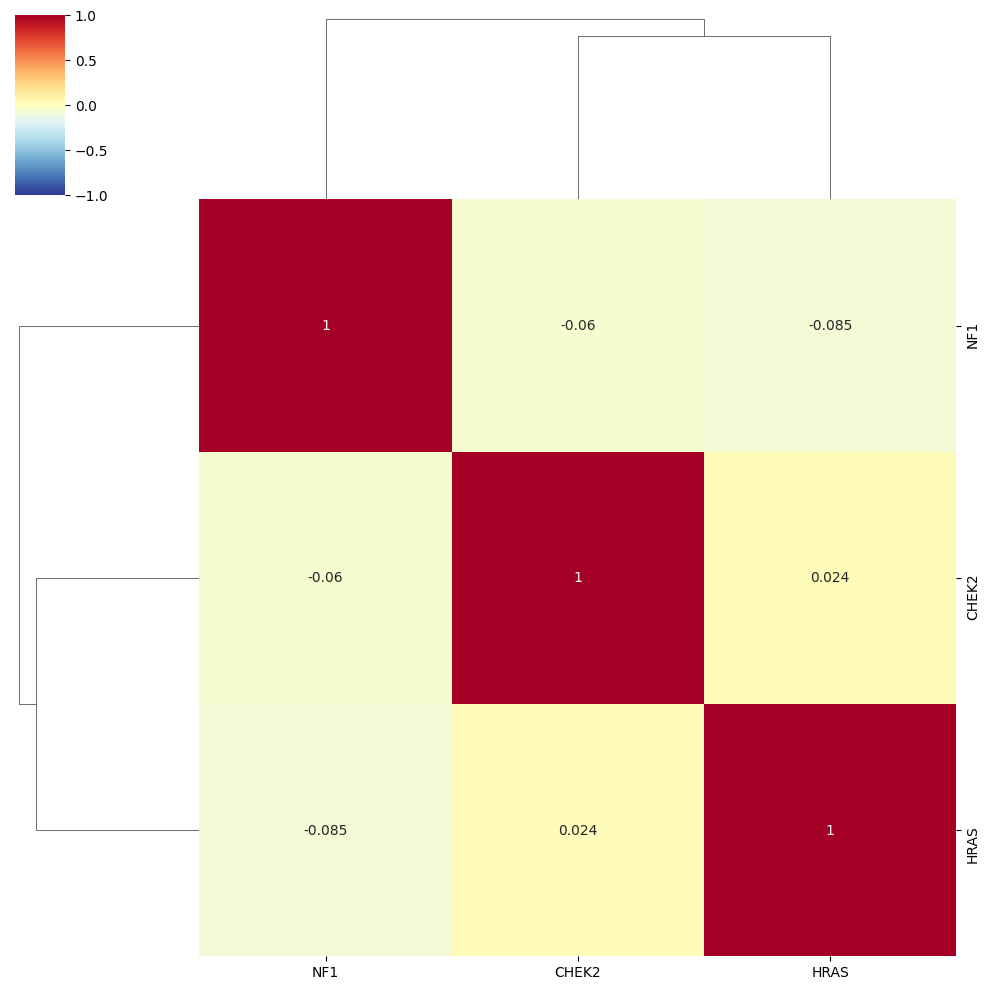

In [9]:
drawing('PCPG')


In [ ]:
drawing('THYM')


In [ ]:
drawing('BLCA')


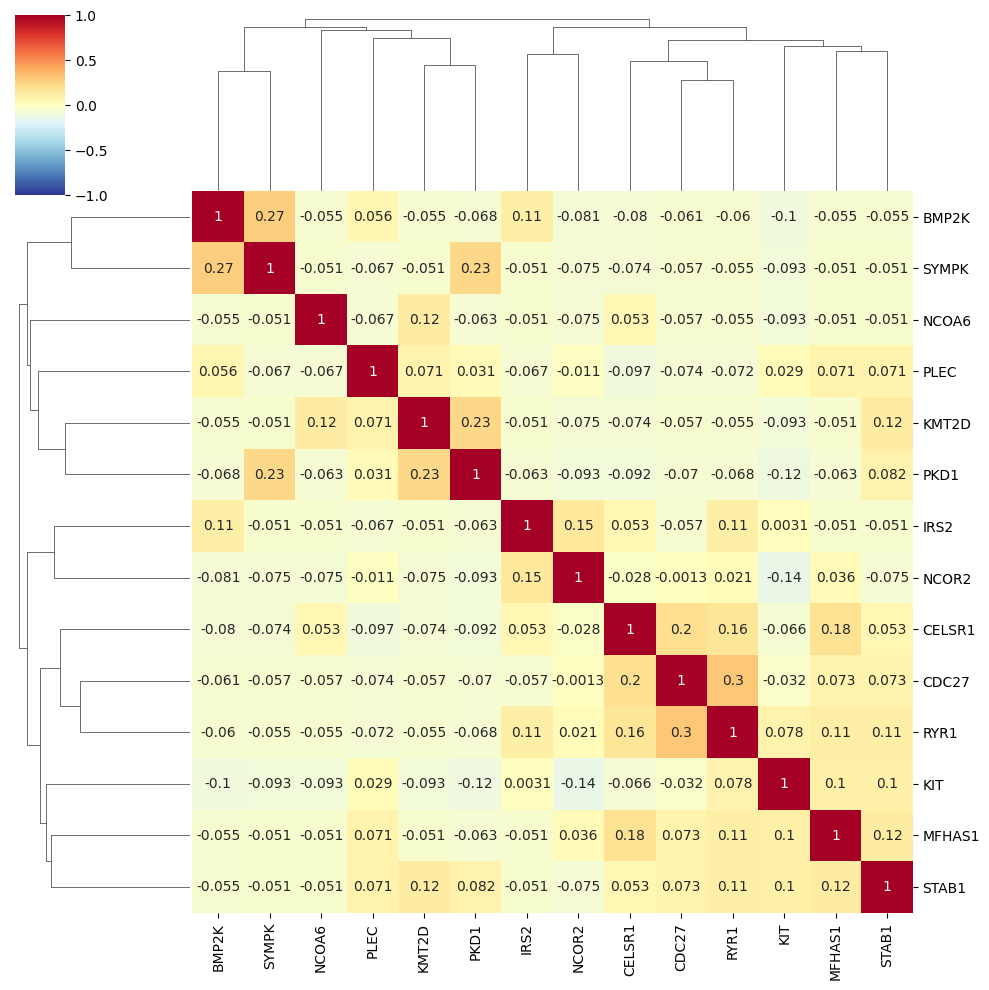

In [7]:
drawing('TGCT')


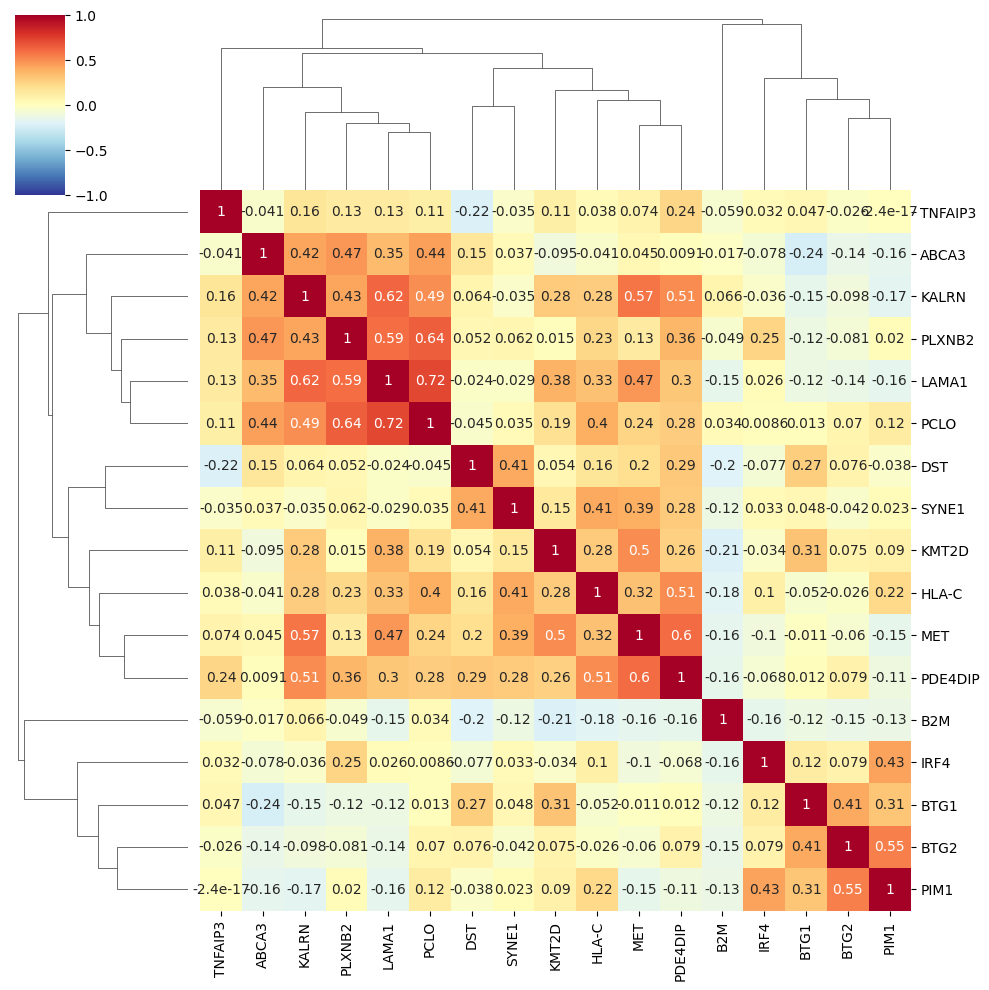

In [6]:
drawing('DLBC')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.clustermap(ccdf.corr(), 
            annot = True,      # 실제 값 화면에 나타내기
            cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
            vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
            )

In [ ]:
def extract_set(cancer_name):
    each_glist = main_genes.get(cancer_name)
    raw =  pd.concat([data, df_test])
    gframe = raw.loc[:, each_glist]
    
    for c in gframe.columns:
        gframe[c] = gframe[c].apply(lambda x : 0 if x =='WT' else len(str(x).split(' ')))
    corr_matrix = gframe.corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            .stack()
            .sort_values(ascending=False))
    aa = sol.reset_index()
    aa.columns =['level0','level1','rate']
    #print(aa)
    set1 = aa[aa.rate >= 0.5]['level0'].drop_duplicates()
    set2 = aa[aa.rate >= 0.5]['level1'].drop_duplicates()
    
    a1 = set() 
    a1.update(set1)
    a1.update(set2)